## imports

In [1]:
from src.load import load_full_aggregate_network, season_rankings_prem_league, name_cleaner
from src.util import AggregateFullTransferNetwork

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

import math

from collections import defaultdict, namedtuple

## Contant run params

In [2]:
start_year = 2000
end_year = 2019

spanish_league = 'spanish_primera_division'
german_league = 'german_bundesliga_1'
french_league = 'french_ligue_1'
italian_league = 'italian_serie_a'


## Task 1: get all nodes that are enlish teams

In [3]:
prem_rankings = season_rankings_prem_league(start_year, end_year)

english_clubs = set()

for year in range(start_year, end_year + 1):
    
    # load the two dataframes
    prem_df = pd.read_csv(f'data/{year}/english_premier_league.csv')
    champ_df = pd.read_csv(f'data/{year}/english_championship.csv')
    
    # get the club names from the "club_name" column 
    year_clubs = list(prem_df['club_name'].unique()) + list(champ_df['club_name'].unique())
    
    # add them to set
    [english_clubs.add(name_cleaner(club)) for club in year_clubs]
    

## Task 2: bin all teams that are not in the english leagues into respective leagues

In [4]:
spanish_clubs = set()
german_clubs = set()
french_clubs = set()
italian_clubs = set()

league_name_clubs = [
    (spanish_league, spanish_clubs, 'spain'), 
    (german_league, german_clubs, 'germany'), 
    (french_league, french_clubs, 'france'), 
    (italian_league, italian_clubs, 'italy')
]


for year in range(start_year, end_year + 1):
    
    for league_name, league_clubs, node_name in league_name_clubs:
        
        # load the dataframe for the year 
        df = pd.read_csv(f'data/{year}/{league_name}.csv')
        
        # get all club names
        [league_clubs.add(club) for club in list(df['club_name'].unique())]
        

## Task 3: make an aggregate transfer network for all years

In [5]:
G = nx.MultiDiGraph()

# add the premier and championship eagues to the the lsit
league_name_clubs += [
    ('english_premier_league', english_clubs, ''), 
    ('english_championship', english_clubs, '')
]

# name of clubs that aren't in any club
na_club = 'other'

for year in range(start_year, end_year+1):
    
    print(f'Reading year {year} for years in range {start_year} to {end_year}', end='\r')
    
    for league_name, league_clubs, node_name in league_name_clubs:
        
        # read in the year's dataframe
        df = pd.read_csv(f'data/{year}/{league_name}.csv')
        
        # go through and add all transfers to the network if they don't already exist
        for idx, row in df.iterrows():
            
            u = row['club_name']
            v = row['club_involved_name']
            
            # if the league name is english, run name cleaner on u
            if 'english' in league_name:
                u = name_cleaner(u)
                
            # otherwise give it the club name
            else:
                u = node_name
                
            other_found = False
            
            # see if v exists in the english league
            if name_cleaner(v) in english_clubs:
                v = name_cleaner(v)
                other_found = True
                
            # otherwise find which club it belongs to, not the english
            for other_league_name, other_league_clubs, other_node_name in league_name_clubs[:4]:
                if v in other_league_clubs:
                    v = other_node_name
                    other_found = True
                    break
                    
            # if we didn't find it, give it to the other bin
            if not other_found:
                v = na_club
                
            # extract the player name, fee (all are in pounds), year, transfer window
            fee = row['fee_cleaned']
            
            if math.isnan(fee):
                fee = 0.0
            else:
                fee = float(fee)
            
            player = row['player_name'].lower()
            year = int(row['year'])
            
            try:
                transfer_window = row['transfer_period'].lower()
            except:
                transfer_window = 'summer'
            
            # if movement is into club, swap u and v
            if row['transfer_movement'] == 'in':
                u, v = v, u
    
            # check to see if this edge exists
            if G.has_edge(u, v) and any(
                [x['player'] == player for _, x in G[u][v].items()]
            ):
                continue
                
            # add our edge
            G.add_edge(u, v, fee=fee, player=player, year=year, transfer_window=transfer_window)

In [6]:
# see how much each club league spent during each year
spending = defaultdict(lambda: defaultdict(lambda: 0))

for u, v, data in G.edges(data=True):
    
    year = data['year']
    
    # see if it was an english team 
    if u in english_clubs:
        u = 'england'
        
    # see if v was an english team 
    if v in english_clubs:
        v = 'england'
        
    # if u and v are the same, we don't care
    if u == v:
        continue
        
    spending[year][u] += data['fee']

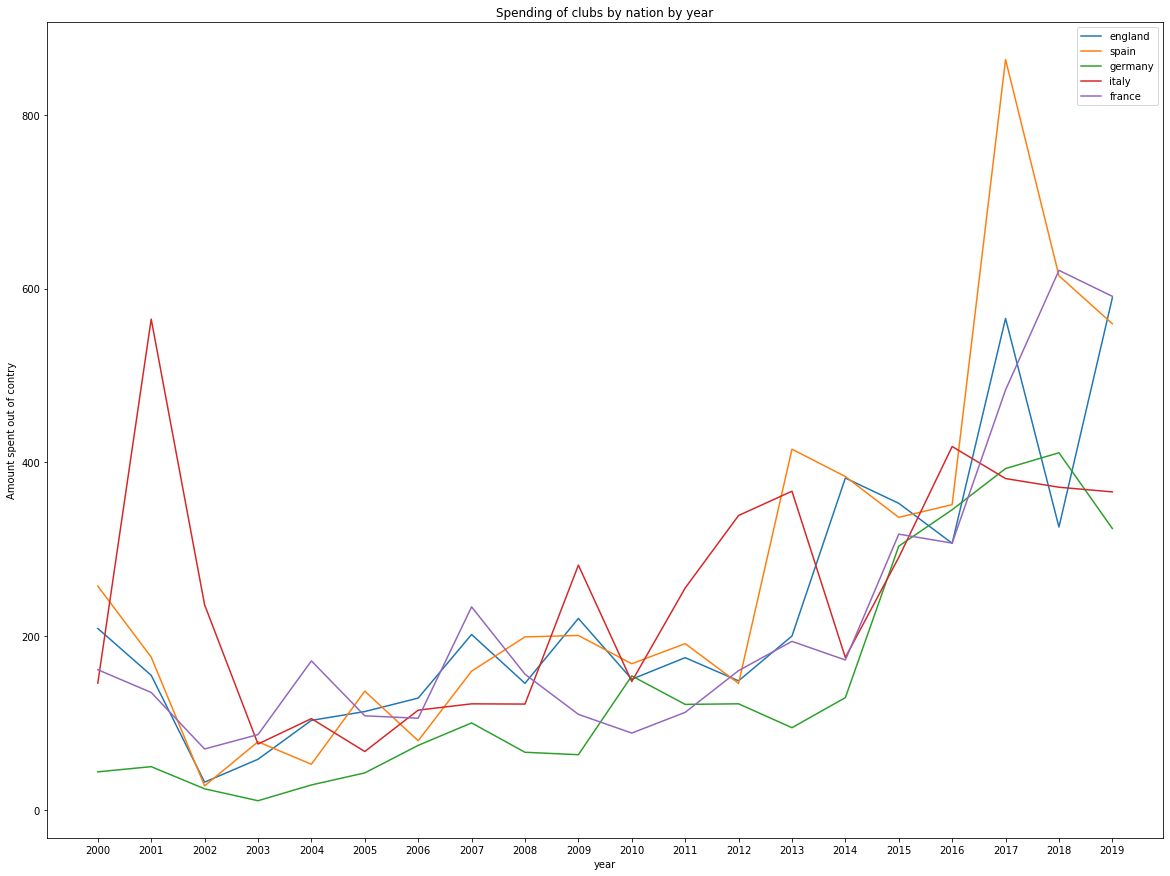

In [7]:
plt.figure(figsize=(20, 15))

# now plot it
for country in ['england', 'spain', 'germany', 'italy', 'france']:
    
    x = list(range(start_year, end_year + 1))
    y = [spending[year][country] for year in range(start_year, end_year + 1)]
    
    plt.plot(x, y, label=country)
    
plt.title('Spending of clubs by nation by year')
plt.xlabel('year')
plt.ylabel('Amount spent out of contry')

plt.xticks([int(x) for x in range(start_year, end_year + 1)])

plt.legend()
    

In [8]:
# go through every player and see what transfer happened in what year 
# and how much they added or subtracted to their worth

PlayerValueDelta = namedtuple(
    'PlayerValueDelta', 
    ['fee_before', 'middle_club', 'fee_after']
)

TransferSummary = namedtuple(
    'TransferSummary', 
    ['from_club', 'to_club', 'year', 'fee']
)

player_transfers = defaultdict(list)

for u, v, data in G.edges(data=True):
    
    # if its the same club, continue
    if u == v: 
        continue
    
    # add the player transfer summart to raw_players
    ts = TransferSummary(u, v, data['year'], data['fee'])
    player_transfers[data['player']].append(ts)
    

In [9]:
player_deltas = defaultdict(list)

for player, transfers in player_transfers.items():
    
    # sort them by year
    sorted_transfers = sorted(transfers, key=lambda x: x.year)
    
    for i, transfer in enumerate(sorted_transfers):
                
        # if its the first one, make an additional pvd of "entry" for the first one
        if i == 0:
            player_deltas[player].append(PlayerValueDelta('entry', transfer.from_club, transfer.fee))
            
        # if its the last one, make an additional one of "exit" for the last one
        if i == len(sorted_transfers) - 1:
            player_deltas[player].append(PlayerValueDelta(transfer.fee, transfer.from_club, 'exit'))
            break
            
        # for all the rest, we need the next transfer
        player_deltas[player].append(PlayerValueDelta(transfer.fee, transfer.to_club, sorted_transfers[i+1].fee))
            

In [10]:
club_deltas = defaultdict(list)

# now we want to count it by club
for player, deltas in player_deltas.items():
    
    for delta in deltas:
        
        # if its a loan, continue
        if delta.fee_after == 0 or delta.fee_before == 0:
            continue
            
        # if its entry or exit, also skip
        if delta.fee_after == 'exit' or delta.fee_before == 'entry':
            continue
        
        club_deltas[delta.middle_club].append(delta.fee_after - delta.fee_before)
    

Text(0, 0.5, 'distribution of fee delta (exit price minus entry price)')

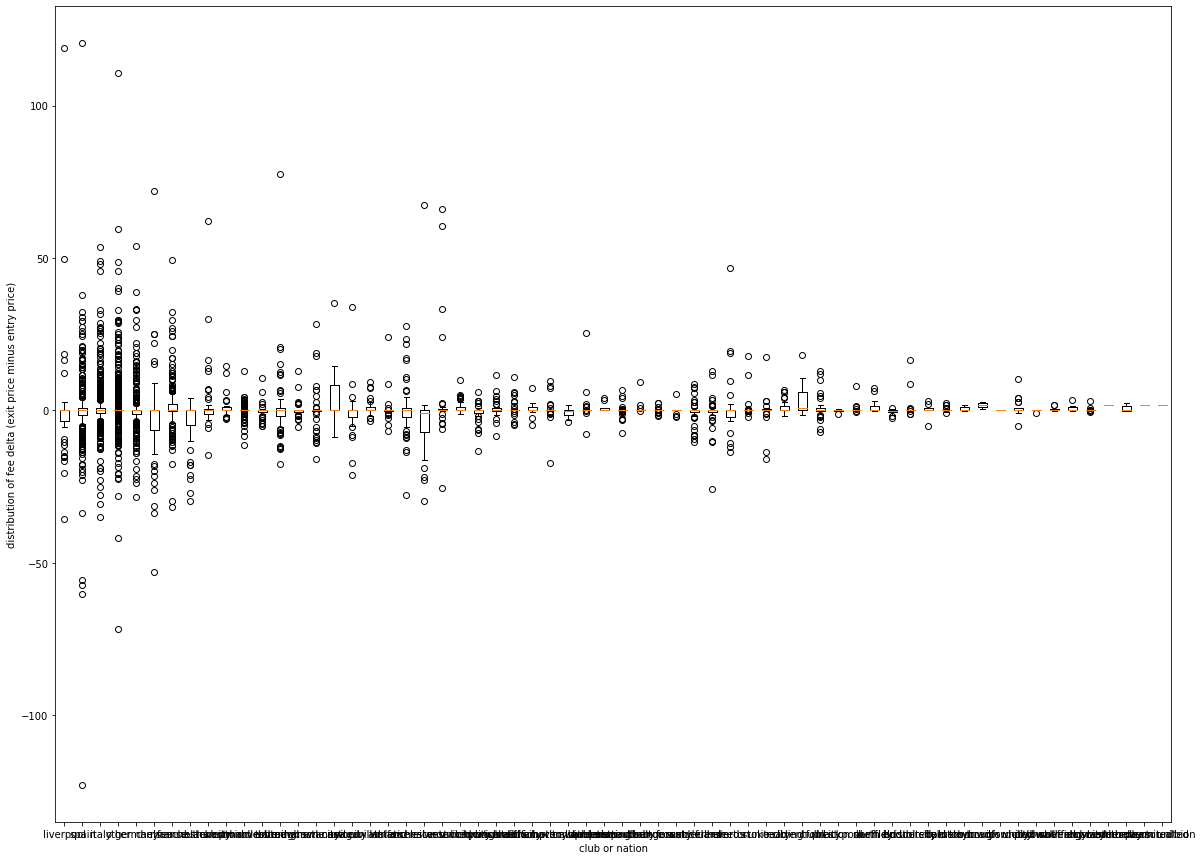

In [11]:
plt.figure(figsize=(20, 15))

data = [v for _, v in club_deltas.items()]
labels = [k for k in club_deltas]

plt.boxplot(data, labels=labels)
plt.xlabel('club or nation')
plt.ylabel('distribution of fee delta (exit price minus entry price)')


([<matplotlib.axis.XTick at 0x7f84b1565090>,
 <a list of 62 Text xticklabel objects>)

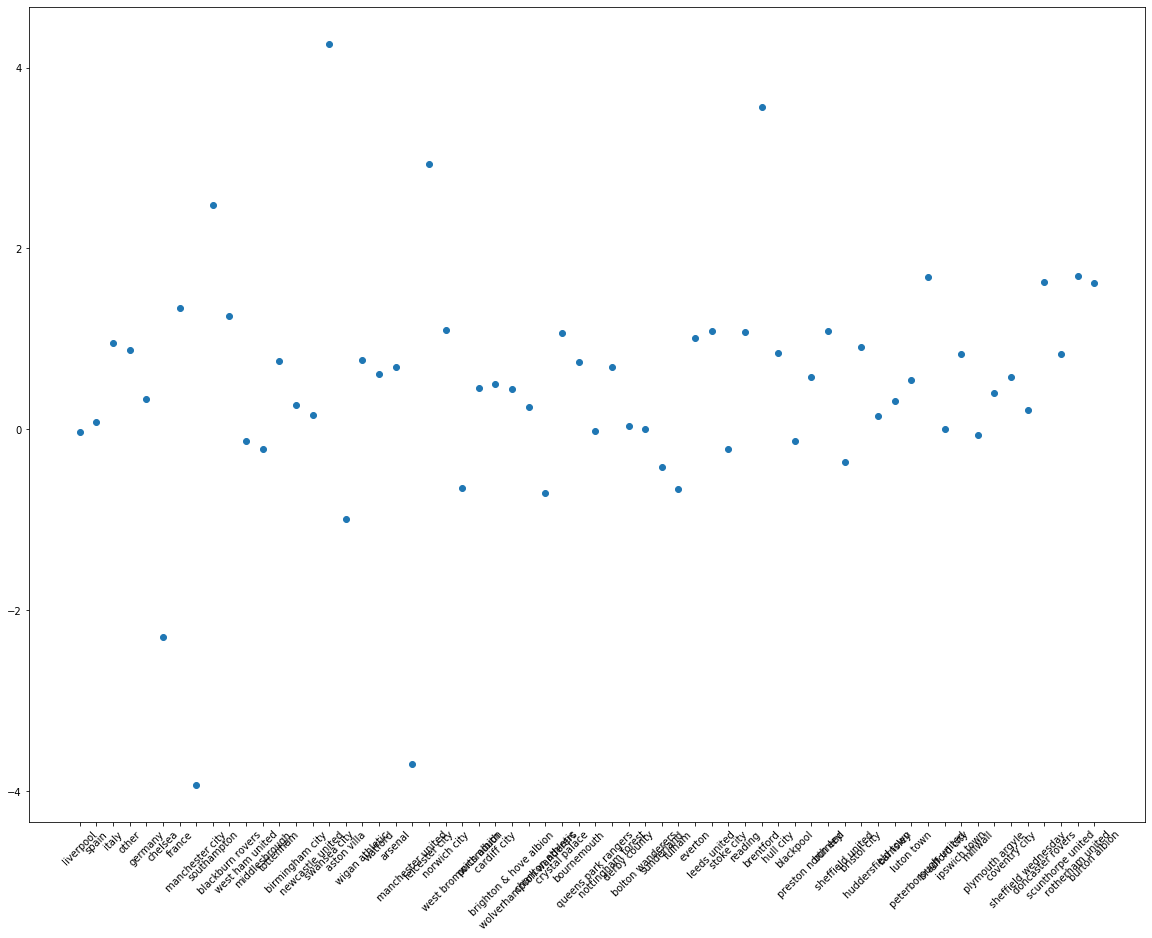

In [12]:
y = [np.mean(v) for _, v in club_deltas.items()]
x = list(range(len(club_deltas)))

plt.figure(figsize=(20, 15))

plt.scatter(x, y)
plt.xticks(range(len(club_deltas)), labels=[k for k in club_deltas], rotation=45)

In [13]:
# go through every player and see what transfer happened in what year 
# and how much they added or subtracted to their worth

PlayerValueDelta = namedtuple(
    'PlayerValueDelta', 
    ['fee_before', 'middle_club', 'fee_after', 'year']
)

TransferSummary = namedtuple(
    'TransferSummary', 
    ['from_club', 'to_club', 'year', 'fee']
)

player_transfers = defaultdict(list)

for u, v, data in G.edges(data=True):
    
    # if u or v in english clubs, make it "england"
    if u in english_clubs:
        u = 'england'
    
    if v in english_clubs:
        v = 'england'
        
    # if u and v are the same, continue
    if u == v:
        continue
    
    # add the player transfer summart to raw_players
    ts = TransferSummary(u, v, data['year'], data['fee'])
    player_transfers[data['player']].append(ts)
    

In [14]:
player_deltas = defaultdict(list)

for player, transfers in player_transfers.items():
    
    # sort them by year
    sorted_transfers = sorted(transfers, key=lambda x: x.year)
    
    for i, transfer in enumerate(sorted_transfers):
                
        # if its the first one, make an additional pvd of "entry" for the first one
        if i == 0:
            player_deltas[player].append(PlayerValueDelta('entry', transfer.from_club, transfer.fee, transfer.year))
            
        # if its the last one, make an additional one of "exit" for the last one
        if i == len(sorted_transfers) - 1:
            player_deltas[player].append(PlayerValueDelta(transfer.fee, transfer.from_club, 'exit', transfer.year))
            break
            
        # for all the rest, we need the next transfer
        player_deltas[player].append(PlayerValueDelta(transfer.fee, transfer.to_club, sorted_transfers[i+1].fee, transfer.year))
            

In [15]:
club_deltas = defaultdict(list)

# now we want to count it by club
for player, deltas in player_deltas.items():
    
    for delta in deltas:
        
        # if its a loan, continue
        if delta.fee_after == 0 or delta.fee_before == 0:
            continue
            
        # if its entry or exit, also skip
        if delta.fee_after == 'exit' or delta.fee_before == 'entry':
            continue
        
        club_deltas[delta.middle_club].append(delta.fee_after - delta.fee_before)
    

Text(0, 0.5, 'distribution of fee delta (exit price minus entry price)')

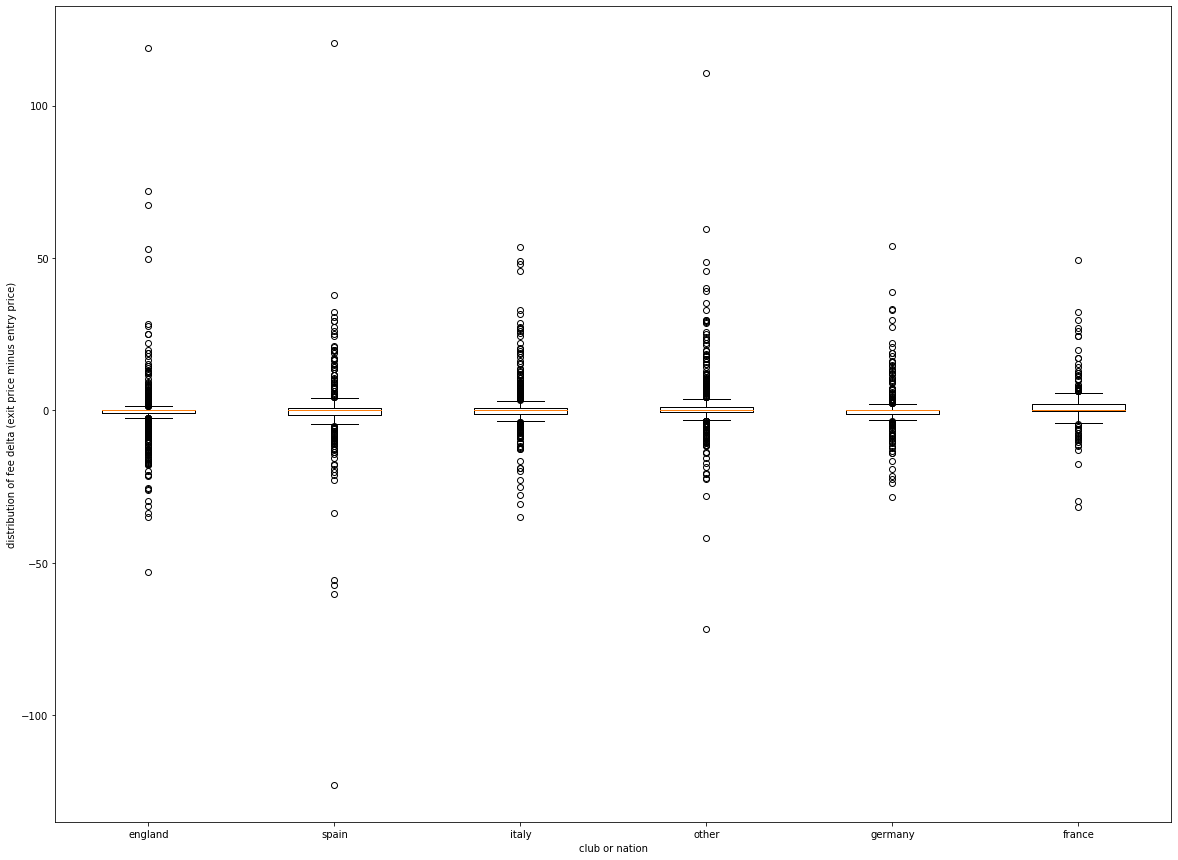

In [16]:
plt.figure(figsize=(20, 15))

data = [v for _, v in club_deltas.items()]
labels = [k for k in club_deltas]

plt.boxplot(data, labels=labels)
plt.xlabel('club or nation')
plt.ylabel('distribution of fee delta (exit price minus entry price)')


([<matplotlib.axis.XTick at 0x7f84c10af1d0>,
 <a list of 6 Text xticklabel objects>)

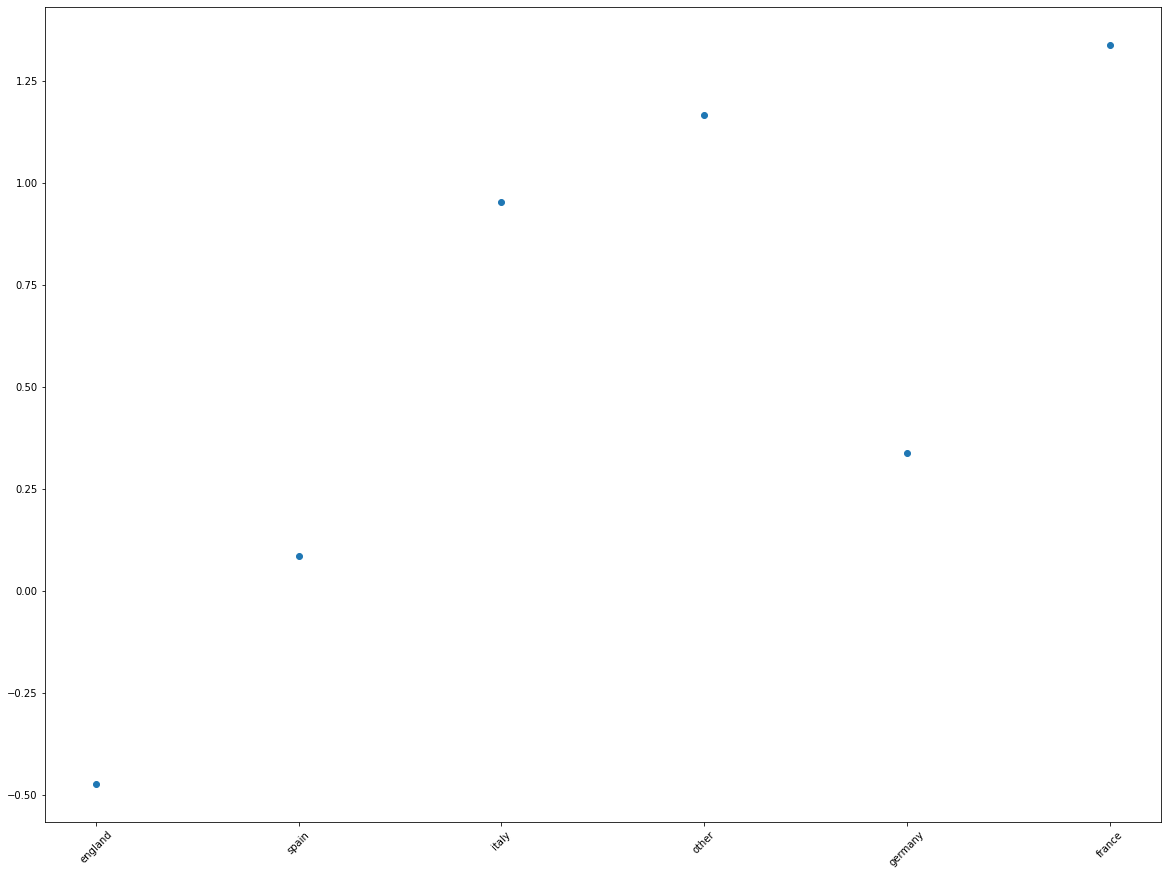

In [17]:
y = [np.mean(v) for _, v in club_deltas.items()]
x = list(range(len(club_deltas)))

plt.figure(figsize=(20, 15))

plt.scatter(x, y)
plt.xticks(range(len(club_deltas)), labels=[k for k in club_deltas], rotation=45)

In [21]:
club_deltas_by_year = defaultdict(lambda: defaultdict(list))

for player, deltas in player_deltas.items():
    for delta in deltas:
        
        if delta.fee_after == 0 or delta.fee_before == 0:
            continue
            
        if delta.fee_before == 'entry' or delta.fee_after == 'exit':
            continue
        
        club_deltas_by_year[delta.middle_club][delta.year].append(delta.fee_after - delta.fee_before)

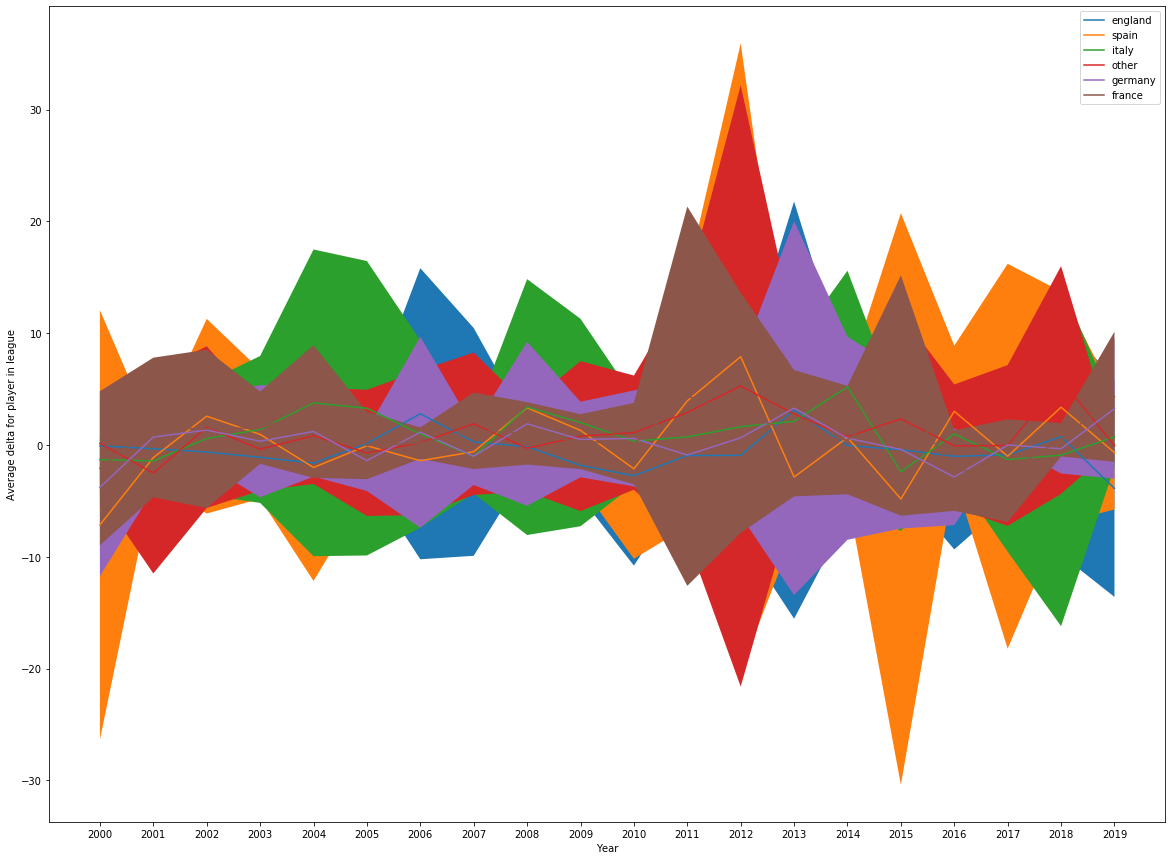

In [24]:
plt.figure(figsize=(20, 15))
x = [int(x) for x in range(start_year, end_year + 1)]

for club, years in club_deltas_by_year.items():
    
    # get the mean, std dev for the year
    ms = []
    above = []
    below = []
    
    for year, deltas in years.items():
        m = np.mean(deltas)
        stddev = np.std(deltas)
        
        ms.append(m)
        above.append(m + stddev)
        below.append(m - stddev)
        
    
    plt.plot(x, ms, label=club)
    plt.fill_between(x, above, below)
    
plt.xlabel('Year')
plt.xticks(x, x)
plt.ylabel('Average delta for player in league')
plt.legend()